**Fachprojekt Dokumentenanalyse** *WS 22/23* -- *Philipp Oberdiek, Gernot A. Fink* -- *Technische Universität Dortmund, Lehrstuhl XII, Mustererkennung in eingebetteten Systemen*
---
# Aufgabe 4: Hauptkomponentenanalyse

Mit dem Nächster Nachbar Klassifikator wurde ein Dokumente zu einer Klassen zugeordnet, indem zunächst ähnliche Dokumente aus einer Trainingsdatenbank ermittelt wurden. Über die Klassenzugehörigkeit dieser ähnlichen Dokumente aus dem Training wurde dann das unbekannte Dokument einer Klasse zugeordnet. Dabei wurden aber noch keine Zusammenhänge zwischen einzelnen Wörtern analysiert und berücksichtigt. Daher geht es nun um Topic Modelle. Topic Modelle beschreiben diese Zusammenhänge durch einen mathematischen Unterraum. Die Vektoren, die diesen Unterraum aufspannen, sind die Topics, die jeweils für typische Wortkonfigurationen stehen. Dokumente werden nun nicht mehr durch Frequenzen von Wörtern repräsentiert, sondern als Linearkombination von Topics im Topic Vektorraum. Es ist zu beachten, dass für die Topic-Modellierung keine Informationen über die Dokumentenkategorien benötigt wird.

Um ein besseres Verständnis für diese mathematischen Unterräume zu entwickeln, schauen wir uns zunächst die Hauptkomponentenanalyse an.

Ein 3D Beispieldatensatz wird aus einer Normalverteilung generiert. Diese ist durch einen Mittelwert und eine Kovarianzmatrix definiert.

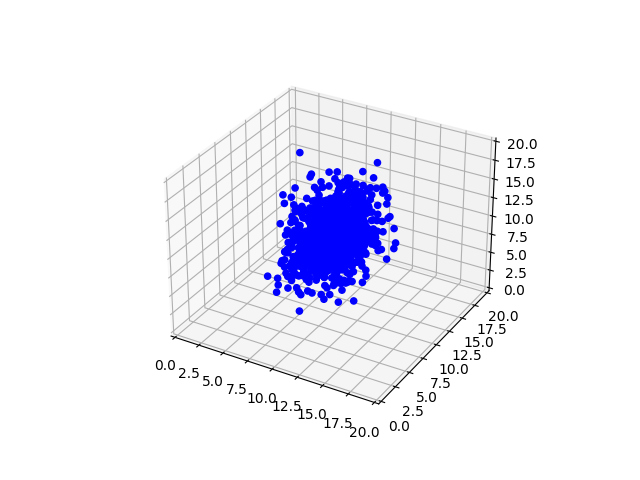

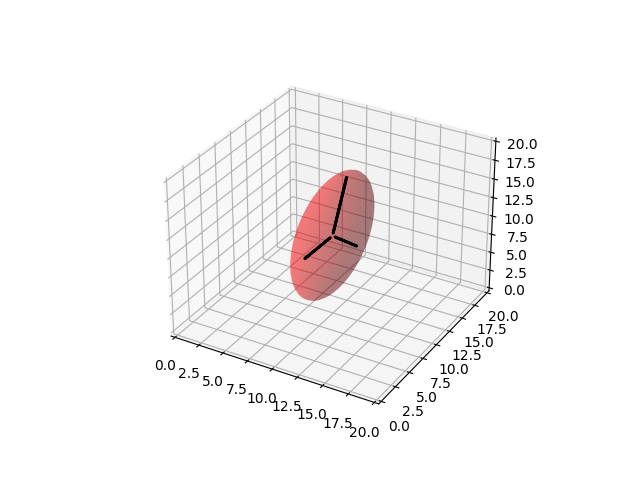

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from common.pca import PCAExample

mean = np.array([10, 10, 10])
cov = np.array([[3, .2, .9],
                [.2, 5, .4],
                [.9, .4, 9]])
n_samples = 1000
limits_samples = ((0, 20), (0, 20), (0, 20))
np.random.seed(42)
samples = np.random.multivariate_normal(mean, cov, n_samples )

# Plotten der Beispieldaten
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
PCAExample.plot_sample_data(samples, ax=ax)
PCAExample.set_axis_limits(ax, limits=limits_samples)

# In der Klasse PCAExample wird ein Unterraum mittels Hauptkomponentenanalyse
# statistisch geschätzt. Der Vektorraum wird beispielhaft visualisiert.
pca_example = PCAExample(samples, target_dim=3)
pca_example.plot_subspace(limits=limits_samples, color='r', linewidth=0.05, alpha=0.3)

Nun wird die Dimension des Unterraums reduziert. Implementieren Sie die Reduktion im Konstruktor von PCAExample. Der neue Vektorraum wird wieder visualisiert.

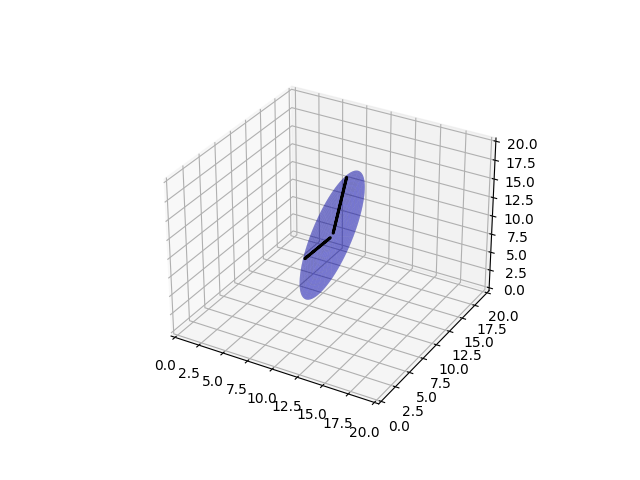

In [3]:
pca_example_2d = PCAExample(samples, target_dim=2)
pca_example_2d.plot_subspace(limits=limits_samples, color='b', linewidth=0.01, alpha=0.3)

Transformieren Sie nun die 3D Beispieldaten in den 2D Unterraum. Implementieren Sie dazu die Methode `transform_samples` im Modul [`pca`](../common/pca.py). Die Daten werden dann in einem 2D Plot dargestellt.

Optional: Verwenden Sie Unterräume mit Dimensionen 3, 2 und 1. Transformieren und plotten Sie die Daten.

Optional: Generieren und transformieren Sie weitere 3D Beispieldaten. Benutzen Sie dabei auch andere Parameter für die Normalverteilung.

Optional: Visualisieren Sie die transformierten 2D Daten auch in dem vorherigen 3D Plot.

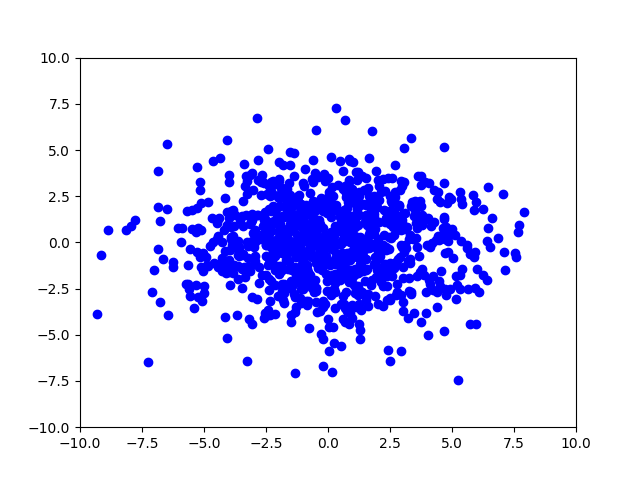

In [4]:
samples_2d = pca_example_2d.transform_samples(samples)
fig = plt.figure()
ax = fig.add_subplot(111)
PCAExample.plot_sample_data(samples_2d, ax=ax)
PCAExample.set_axis_limits(ax, limits=((-10, 10), (-10, 10)))

Berechnen Sie nun die Kovarianzmatrix der transformierten Daten. Welche Eigenschaften hat diese Matrix? (Dimension, etc.) In welcher Grössenordnung liegen die einzelnen Einträge? Erklären Sie das anhand des vorherigen 2D Plots. Vergleichen Sie das Ergebnis mit der Kovarianzmatrix, die oben zur Generierung der Daten verwendet wurde. Was erwarten Sie für den Mittelwert der transformierten Daten (nötig für die Berechnung der Kovarianzmatrix)?

Verwenden Sie bei der Berechnung nicht die eingebaute `numpy.cov` Funktion (höchstens zur Kontrolle, achten Sie dabei auf den "bias" Parameter). Verwenden Sie bei der Berechnung keine Schleifen, sondern nur Matrixoperationen. Erklären Sie die Vorgehensweise.

In [5]:
# calculate the cov matrix
n_samples = samples_2d.shape
samples_2d_mean = np.sum(samples_2d, axis=0) / n_samples
X = samples_2d - samples_2d_mean
samples_2d_cov = np.dot(X.T, X) / n_samples
print("cov" , samples_2d_cov)

cov [[ 8.65700243e+00 -1.45661261e-13]
 [-2.91322522e-16  2.51310688e+03]]


## Latent Semantic Indexing

Im folgenden soll ein Topic-Raum mittels Latent Semantic Indexing verwendet werden. Das Prinzip geht unmittelbar auf die Hauptkomponentenanalyse zurück. Siehe: http://lsa.colorado.edu/papers/JASIS.lsi.90.pdf (Seite 12)  
Grundsätzlicher Unterschied ist, dass der Unterraum nicht durch eine Eigenewertanalyse der Kovarianzmatrix bestimmt wird. Stattdessen ergibt sich der Unterraum aus einer Zerlegung der Term-Dokument (!) Matrix mit einer Singulärwertzerlegung. Man kann zeigen, dass diese Singulärwertzerlegung implizit einer Eigenwertanalyse einer Termkorrelationsmatrix entspricht. Deren Berechnung unterscheidet sich von der Berechnung der Kovarianzmatrix insbesondere darin, dass die Daten nicht vom Mittelwert befreit werden.

Sei $t$ die Anzahl der Terms (Grösse des Vokabulars), $d$ die Anzahl der Dokumente, $m$ der Rang von $X$ (Maximale Anzahl von Topics, die sich aus $X$ bestimmen lassen). $D'$ ist die Transponierte von $D$.

  $$\underbrace{X}_{t\times d}=\underbrace{T}_{t\times m}*\underbrace{S}_{m\times m}*\underbrace{D'}_{m\times d}$$

In Analogie zur Hauptkomponentenanalyse findet man nun die Vektoren, die den Unterraum aufspannen, in den Spalten von $T$. Die Matrix $S$ hat nur Einträge auf der Diagonalen und enthält die Singulärwerte zu den Spaltenvektoren in $T$. ($T$ und $D$ enthalten die linken respektive rechten Singulärvektoren.) Die Singulärwerte entsprechen den Eigenwerten in der Hauptkomponentenanalyse. Sie sind ein Maß für die Variabilität in den einzelnen Topics. Bei $D$ handelt es sich um die Koeffizienten der $d$ Dokumente im Topic Raum (Ergebnis der Transformation von den Bag-of-Words Repräsentationen aus $X$ in den Topic Raum.)

Aus der Singulärwertzerlegung (Formel oben) ergibt sich, wie man einen Topic-Raum statistisch aus Beispieldaten schätzt. Um den Topic-Raum aber mit unbekannten Daten zu verwenden, müssen diese in den Topic-Raum transformiert werden. Stellen Sie dazu die obige Formel nach $D$ um. Die zu transformierenden Bag-of-Words Repäsentationen können dann für $X$ eingesetzt werden. Dabei ist wichtig zu beachten:

- Die Spaltenvektoren in $T$ sind orthonormal (zueinander) $T' * T = I$
- Die Spaltenvektoren in $D$ sind orthonormal (zueinander) $D' * D = I$
- Dabei ist $I$ die Einheitsmatrix, $T'$ und $D'$ sind die Transponierten in $T$ und $D$.
- Für Matrizen $A$ und $B$ gilt: $(A * B)' = B' * A'$

Überlegen Sie wie die Transponierte einer Matrix gebildet wird und was das für eine Matrix bedeutet, deren Einträge nur auf der Hauptdiagonalen von 0 verschieden sind.

Erläutern Sie die Funktion der einzelnen Matrizen in der sich ergebenden Transformationsvorschrift.

**Antworten:**

- Nach $D$ umgestellte Formel:

- Funktionen der einzelnen Matrizen:


S- * T- * X = D-.T = D

Das Schätzen eines Topic-Raums soll an folgendem einfachen Beispiel veranschaulicht werden. Sei dazu `bow_train` eine Dokument-Term Matrix mit 9 Dokumenten und 3 Terms. Welcher Zusammenhang zwischen den Terms fällt Ihnen auf?

In [6]:
bow_train = np.array([[2, 5, 0],
                      [4, 1, 0],
                      [3, 3, 1],
                      [9, 8, 2],
                      [1, 5, 3],
                      [0, 7, 9],
                      [2, 9, 6],
                      [0, 2, 3],
                      [5, 3, 3]])

# Zerlegung der Dokument-Term Matrix mit der Singulärwertzerlegung
T, S_arr, D_ = np.linalg.svd(bow_train.T, full_matrices=False)
S = np.diag(S_arr)
print('Matrix T, Spaltenvektoren definieren Topic Raum')
print(T)
print('Matrix S, Singulärwerte zu den Vektoren des Topic Raums')
print(S)
print('Matrix D, Koeffizienten der Termvektoren in bof im Topic Raum')
print(D_.T)

Matrix T, Spaltenvektoren definieren Topic Raum
[[-0.41334067  0.8048751   0.42582339]
 [-0.76349026 -0.05150169 -0.64376254]
 [-0.49621781 -0.59120525  0.63580204]]
Matrix S, Singulärwerte zu den Vektoren des Topic Raums
[[21.13984123  0.          0.        ]
 [ 0.          9.69683725  0.        ]
 [ 0.          0.          3.88309932]]
Matrix D, Koeffizienten der Termvektoren in bof im Topic Raum
[[-0.21968626  0.13945183 -0.60960736]
 [-0.11432692  0.32670433  0.27285705]
 [-0.1904797   0.17210921 -0.00463944]
 [-0.51184981  0.58260768 -0.01186828]
 [-0.2705529  -0.12645867 -0.22806091]
 [-0.46407123 -0.58589816  0.31312117]
 [-0.50498963 -0.24760615 -0.29033607]
 [-0.14265168 -0.19352899  0.15963564]
 [-0.27653129  0.21617922  0.54215339]]


Transformieren Sie nun die folgenden Termvektoren in den Topic Raum
Was erwarten Sie für die Topic Zugehörigkeiten?

In [7]:
bow_test = np.array([[5, 0, 0],
                     [0, 5, 0],
                     [0, 0, 5],
                     [5, 5, 0],
                     [0, 5, 5]])

# Zerlegung der Dokument-Term Matrix mit der Singulärwertzerlegung
T, S_arr, D_ = np.linalg.svd(bow_test.T, full_matrices=False)
S = np.diag(S_arr)
print('Matrix T, Spaltenvektoren definieren Topic Raum')
print(T)
print('Matrix S, Singulärwerte zu den Vektoren des Topic Raums')
print(S)
print('Matrix D, Koeffizienten der Termvektoren in bof im Topic Raum')
print(D_.T)


Matrix T, Spaltenvektoren definieren Topic Raum
[[-4.08248290e-01  7.07106781e-01  5.77350269e-01]
 [-8.16496581e-01  4.44089210e-16 -5.77350269e-01]
 [-4.08248290e-01 -7.07106781e-01  5.77350269e-01]]
Matrix S, Singulärwerte zu den Vektoren des Topic Raums
[[10.          0.          0.        ]
 [ 0.          7.07106781  0.        ]
 [ 0.          0.          5.        ]]
Matrix D, Koeffizienten der Termvektoren in bof im Topic Raum
[[-2.04124145e-01  5.00000000e-01  5.77350269e-01]
 [-4.08248290e-01  3.26357052e-16 -5.77350269e-01]
 [-2.04124145e-01 -5.00000000e-01  5.77350269e-01]
 [-6.12372436e-01  5.00000000e-01  1.62409393e-17]
 [-6.12372436e-01 -5.00000000e-01 -2.14162521e-16]]


Warum lassen sich die Koeffizienten der Termvektoren so schwer interpretieren?

Um eine bessere Vorstellung von der Bedeutung der einzelnen Topics zu bekommen, plotten Sie die Bag-of-Words Repräsentationen sowie die Topic-Koeffizienten der Trainingsdaten (`bow_train`) und der Testdaten (`bow_test`) in verschiedenen Farben. Erstellen Sie dazu jeweils einen Plot für Bag-of-Words Repräsentationen und einen Plot für Topic-Koeffizienten. Achten Sie auf eine geeignete Skalierung der Axen. Um die Datenpunkte in den beiden Plots besser einander zuordnen zu können, plotten Sie zusätzlich die Termfrequenzen neben jeden Datenpunkt (als Annotation). Mehrere Daten (Trainings-, Testdaten, Annotationen) lassen sich in einem gemeinsamen Plot darstellen indem sie nacheinander zu dem gleichen Axis Objekt hinzugefügt werden. Zum Erstellen der Plots orientieren Sie sich an den entsprechenden Funktionen aus dem Beispiel zur Hauptkomponentenanalyse (oben). Schauen Sie sich auch deren weitere Parameter (und zusätzlich vorhandene Hilfsfunktionen) an.

train=blue  test=red


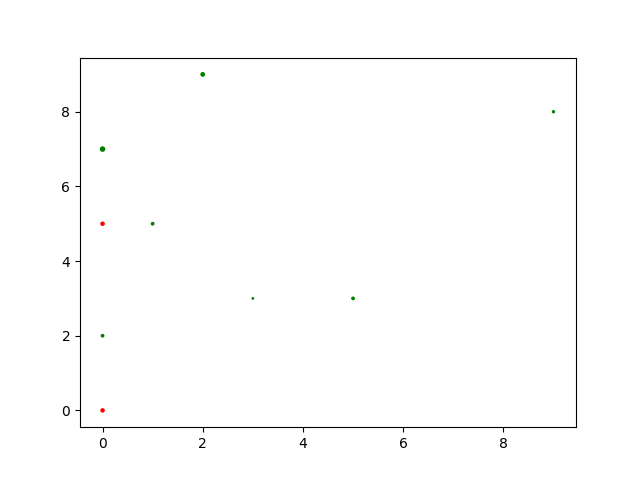

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
print("train=blue  test=red")
PCAExample.plot_sample_data(bow_train, ax=ax , color='g')
PCAExample.plot_sample_data(bow_test, ax=ax , color='r')

train=blue  test=red


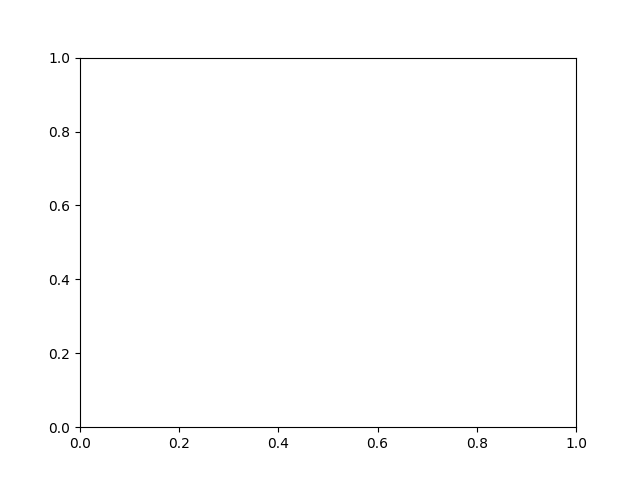

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
print("train=blue  test=red")
PCAExample.plot_sample_data(D_, ax=ax)

Führen Sie nun eine Dimensionsreduktion der Trainings und Testdaten auf zwei Dimensionen durch und plotten Sie die Topic-Koeffizienten (inkl. Bag-of-Words Annotationen). Vergleichen Sie alle drei Plots miteinander. Welchen Effekt hat die Topic Modellierung im Bezug auf typische Termkonfigurationen?

Optional: Transformieren Sie die Daten in einen Topic-Raum mit Dimension Eins und plotten Sie die Koeffizienten inkl. deren Bag-of-Words Annotationen.

Integrieren Sie nun die Topic-Raum Modellierung mittels Singulärwertzerlegung in die Kreuzvalidierung auf dem Brown Corpus. Berechnen Sie dabei für jede Aufteilung von Training und Test einen neuen Topic-Raum. Transformieren Sie die Bag-of-Words Repräsentationen und führen Sie die Klassifikation wie zuvor mit dem Nächster-Nachbar-Klassifikator durch. Verwenden Sie dabei verschiedene Distanzmaße und evaluieren Sie die Klassifikationsfehlerrate für verschiedene Dimensionalitäten des Topic-Raums. Die anderen Parameter wählen Sie gemäß der besten bisherigen Ergebnisse.

Implementieren Sie die Klasse `TopicFeatureTransform` im [`features`](../common/features.py) Modul und verwenden Sie sie mit der `CrossValidation` Klasse ([`evaluation`](../common/evaluation.py) Modul).

Optional: Führen Sie eine automatische Gridsuche über dem kompletten Paramterraum durch. Legen Sie sinnvolle Wertebereiche und Schrittweiten für die einzelnen Parameter fest. Wie lassen sich diese bestimmen?

Optional: Passen Sie das Suchgrid dynamisch gemäß der Ergebnisse in den einzelnen Wertebereichen an.

In [ ]:
from common.corpus import CorpusLoader
CorpusLoader.load()
brown = CorpusLoader.brown_corpus()

